### demonstrating AprilTags  20221221 CJH
### update 20230402 for Robotpy's Apriltag

#### import the necessary libraries

In [1]:
import robotpy_apriltag as ra  # apriltag processor
from wpimath.geometry import Transform3d
from wpimath.estimator import SwerveDrive4PoseEstimator
import cv2  # image acquisition and manipulation
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [2]:
# modified from https://gist.github.com/lobrien/5d5e1b38e5fd64062c43ac752b74889c
# todo - generate fx and fy from fov parameters BECAUSE THE EXAMPLE BELOW IS WRONG
def get_apriltag_detector_and_estimator(frame_size):
    detector = ra.AprilTagDetector()
    # FRC 2023 uses tag16h5 (game manual 5.9.2)
    assert detector.addFamily("tag16h5")
    estimator = ra.AprilTagPoseEstimator(
    ra.AprilTagPoseEstimator.Config(
            tagSize=0.2, fx=500, fy=500, cx=frame_size[1] / 2.0, cy=frame_size[0] / 2.0)
    )
    return detector, estimator

In [3]:
# create a detector object
at_detector, estimator = get_apriltag_detector_and_estimator(frame_size=[640,480])

#### get an image from camera  - can be webcam or external USB
* you can skip this if you want to use the same image I did - it's saved on the disk; see below

In [31]:
resolution = (640, 480)
cam = cv2.VideoCapture(1, cv2.CAP_DSHOW)  # open a regular USB cam
cam.set(cv2.CAP_PROP_FRAME_WIDTH, resolution[0])
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, resolution[1])
s, image_raw = cam.read()  # read from the camera
if s > 0:  # test if the camera actually returned a success
    #s, image_raw = cam.read()  # read from the camera
    cv2.imshow(f'Image Processing Pipeline', image_raw)
cam.release()
# close video display on key press
cv2.waitKey(0)
cv2.destroyAllWindows()

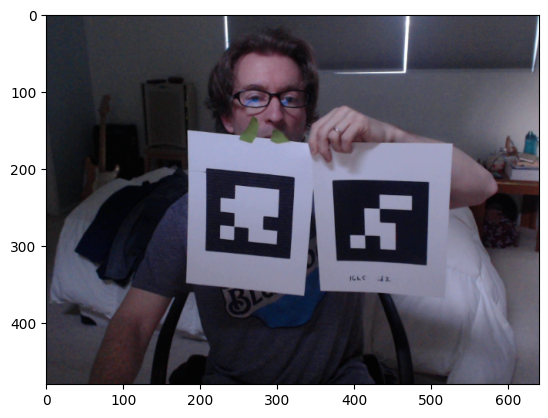

In [32]:
plt.imshow(cv2.cvtColor(image_raw, cv2.COLOR_BGR2RGB))

In [33]:
# in case we need it later
test_images = Path(".") / 'test_images'  # directory for the calibration images
# cal_images.absolute()
save_images = False
if save_images:
    plt.imsave(test_images / '16h5_test_1280_z4p00m.png', image_raw)
    # cv does not accept Paths
    cv_image = test_images / '16h5_test_cv_1280_z4p00m.png'
    cv2.imwrite(str(cv_image), image_raw)

In [34]:
# I want to keep looking at these images
load_images = False
if load_images:
    cv_image = test_images / '16h5_test_cv_1280_z4p00m.png'
    image_raw = cv2.imread(str(cv_image))

In [35]:
# this detector fails on color images
grey_image = cv2.cvtColor(image_raw, cv2.COLOR_BGR2GRAY)

#### generate some detections, call them tags

In [36]:
%%time 
detections = at_detector.detect(grey_image)
print(f'Number of detections: {len(detections)}')
tags = [det for det in detections if det.getHamming() < 2]
tag = detections[0] if len(detections) > 0 else None

Number of detections: 6
CPU times: total: 0 ns
Wall time: 7 ms


In [37]:
methods = ['getCenter',  'getDecisionMargin',  'getFamily',  'getHamming',
 'getHomography',  'getHomographyMatrix',  'getId']
for method in methods:
    print(f'Method: {method:20} Result: {getattr(tag, method)()}')

Method: getCenter            Result: Point(x=434.1092967416366, y=271.02194379006505)
Method: getDecisionMargin    Result: 127.60771179199219
Method: getFamily            Result: tag16h5
Method: getHamming           Result: 0
Method: getHomography        Result: (52.816002171929995, 16.667316676379766, 434.1092967416366, -2.478438098917832, 62.90532137951567, 271.02194379006505, -0.017753594923690545, 0.03671138327091816, 1.0)
Method: getHomographyMatrix  Result: [[ 5.28160022e+01  1.66673167e+01  4.34109297e+02]
 [-2.47843810e+00  6.29053214e+01  2.71021944e+02]
 [-1.77535949e-02  3.67113833e-02  1.00000000e+00]]
Method: getId                Result: 2


In [38]:
tag.getCorner(0)

Point(x=377.4052429199218, y=319.02975463867193)

In [39]:
# needs a tuple to return, I guess
tag.getCorners([0]*8)

(377.4052429199218,
 319.02975463867193,
 494.2232360839843,
 325.2821960449219,
 497.34591674804693,
 217.483413696289,
 371.67205810546886,
 214.6646270751953)

In [40]:
est = estimator.estimateOrthogonalIteration(tag, 50)

In [41]:
est.getAmbiguity()

0.35066065925368806

In [42]:
est.pose1

Transform3d(Translation3d(x=0.334479, y=-0.084325, z=0.872147), Rotation3d(x=0.538676, y=0.523975, z=0.093719))

In [43]:
est.pose2

Transform3d(Translation3d(x=0.338319, y=-0.091375, z=0.871628), Rotation3d(x=-0.254202, y=0.150568, z=0.051840))

In [44]:
est.pose2.translation()

Translation3d(x=0.338319, y=-0.091375, z=0.871628)

In [45]:
%%time 
detections = at_detector.detect(grey_image)
detections2 = [det for det in detections if det.getHamming() < 2]
detections2

CPU times: total: 31.2 ms
Wall time: 11 ms


[<AprilTagDetection tag_family=tag16h5 tag_id=2 hamming=0 decision_margin=127.60771179199219 center=Point(x=434.1092967416366, y=271.02194379006505)>,
 <AprilTagDetection tag_family=tag16h5 tag_id=4 hamming=1 decision_margin=0.5911462306976318 center=Point(x=495.1625114767353, y=185.24128525749163)>,
 <AprilTagDetection tag_family=tag16h5 tag_id=5 hamming=0 decision_margin=106.53108215332031 center=Point(x=264.0453672293827, y=260.3234438790883)>]

#### looks like
* positive x means the tag is on the right
* negative y means the tag is above center
* positive z is obvious, it is the distance from the center of the camera

In [46]:
# process our image with the info from detector
def pipeline(img, intrinsics=None, tag_size=0.1524):
    img_copy = img.copy()
    grey_image = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
    if intrinsics is None:
        detections = at_detector.detect(grey_image)
    else:
        detections = at_detector.detect(grey_image, estimate_tag_pose=True, camera_params=intrinsics, tag_size=tag_size)
    
    detections = [detection for detection in detections if detection.getHamming() < 2]
    for idy, detection in enumerate(detections):
    
        color = ([255*int(i) for i in f'{(idy+1) % 7:03b}'])  # trick for unique colors
        center = detection.getCenter()
        center = [int(center.x), int(center.y)]
        
        img_copy = cv2.putText(img_copy, f'{detection.getId():2d}', center, cv2.FONT_HERSHEY_SIMPLEX,1, color, 2) 
        corners = np.array(detection.getCorners([0]*8)).reshape((-1, 1, 2)).astype(dtype=np.int32)
        # corners = np.array([ [int (c) for c in corner] for corner in detection.getCorners([0]*8) ]).reshape((-1, 1, 2))
        img_copy = cv2.polylines(img_copy, [corners], isClosed=True, color=color, thickness=2)
  
    return img_copy, detections

In [47]:
# if you want to show the image with opencv as a separate window
cv2.imshow('Processed', pipeline(image_raw)[0])
cv2.waitKey(0)
cv2.destroyAllWindows()

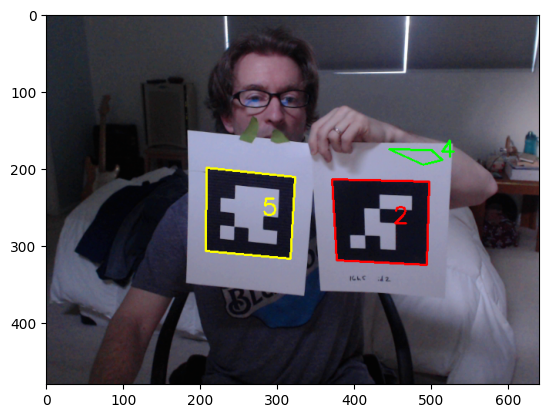

In [48]:
# show it with matplotlib instead
processed_image, tags = pipeline(image_raw)
plt.imshow(cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB))

In [49]:
print('Summary of results')
for tag in tags:
    print(f'ID: {tag.getId():2}    hamming: {tag.getHamming()}   decision_margin: {tag.getDecisionMargin():2.2f}')

Summary of results
ID:  2    hamming: 0   decision_margin: 127.61
ID:  4    hamming: 1   decision_margin: 0.59
ID:  5    hamming: 0   decision_margin: 106.53


In [23]:
# with perspective, from the pose detected


#### more apriltag tricks from FRC library

In [24]:
field_layout = ra.AprilTagFieldLayout?

Docstring:     
Class for representing a layout of AprilTags on a field and reading them from
a JSON format.

The JSON format contains two top-level objects, "tags" and "field".
The "tags" object is a list of all AprilTags contained within a layout. Each
AprilTag serializes to a JSON object containing an ID and a Pose3d. The
"field" object is a descriptor of the size of the field in meters with
"width" and "length" values.  This is to account for arbitrary field sizes
when transforming the poses.

Pose3ds in the JSON are measured using the normal FRC coordinate system, NWU
with the origin at the bottom-right corner of the blue alliance wall.
SetOrigin(OriginPosition) can be used to change the poses returned from
GetTagPose(int) to be from the perspective of a specific alliance.

Tag poses represent the center of the tag, with a zero rotation representing
a tag that is upright and facing away from the (blue) alliance wall (that is,
towards the opposing alliance).
Init docstring:
__init_

### fake a field pose estimator and update it with the vision

In [25]:
field_layout.getTagPose(8)

NameError: name 'field_layout' is not defined

#### tricks to get things to work

In [26]:
corners = [ [int (c) for c in corner] for corner in detections[1].corners ]
corners

AttributeError: 'robotpy_apriltag._apriltag.AprilTagDetection' object has no attribute 'corners'

In [27]:
sorted(corners, key=lambda x: (x[1], x[0] ))

NameError: name 'corners' is not defined

In [28]:
# color trick
for ix in range(8):
    color = ([255*int(i) for i in f'{(ix+1) % 7:03b}'])
    print(color, )

[0, 0, 255]
[0, 255, 0]
[0, 255, 255]
[255, 0, 0]
[255, 0, 255]
[255, 255, 0]
[0, 0, 0]
[0, 0, 255]


In [29]:
# getting corners for cv polylines
corners = np.array([ [int (c) for c in corner] for corner in detections[1].corners ])
corners.reshape((-1, 1, 2))

# corners = np.array([ [int (c) for c in corner] for corner in detections[1].corners ]).reshape((-1, 1, 2))
# img_copy = cv2.polylines(img_copy, [corners], isClosed=True, color=color, thickness=2)

AttributeError: 'robotpy_apriltag._apriltag.AprilTagDetection' object has no attribute 'corners'

In [30]:
# trying a manual corner sort that doesn't always work for drawing a box with lines
corners = [ [int (c) for c in corner] for corner in detections[1].corners ]
corners = sorted(corners, key=lambda x: (x[1]))  # sort from top to bottom
if (corners[0][0] > corners[1][0]) and (corners[2][0] > corners[3][0]):  # swap if 1st and 3rd on same side 
    corners[2], corners[3] = corners[3], corners[2]
corners
# for idx, corner in enumerate(corners):
#     img_copy = cv2.line(img_copy, corner, corners[(idx+1)%4], color, 2)

AttributeError: 'robotpy_apriltag._apriltag.AprilTagDetection' object has no attribute 'corners'